In [ ]:
from google.colab import drive
drive.mount("/gdrive")

Mounted at /gdrive


In [ ]:
zip_path = "/gdrive/MyDrive/Colab_data/FL_MNIST/fl_mnist.zip"
!cp -R {zip_path} .

In [ ]:
!unzip fl_mnist.zip

In [ ]:
import numpy as np
import pandas as pd
import random
import cv2
import os
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import expand_dims
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Input, Lambda
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import backend as K

In [ ]:
!pip install imutils -q
from imutils import paths

In [ ]:
debug = 0

In [ ]:
def load(paths, verbose=-1):
    '''expects images for each class in seperate dir, 
    e.g all digits in 0 class in the directory named 0 '''
    data = list()
    labels = list()
    # loop over the input images
    for (i, imgpath) in enumerate(paths):
        # load the image and extract the class labels        
        im_gray = cv2.imread(imgpath , cv2.IMREAD_GRAYSCALE)
        image = np.array(im_gray).flatten() # cv2.imread(imgpath) 
        # print(image.shape)
        label = imgpath.split(os.path.sep)[-2]
        # scale the image to [0, 1] and add to list
        data.append(image/255)
        labels.append(label)
        # show an update every `verbose` images
        if verbose > 0 and i > 0 and (i + 1) % verbose == 0:
            print("[INFO] processed {}/{}".format(i + 1, len(paths)))
    # return a tuple of the data and labels
    
    return data, labels

def create_clients(image_list, label_list, num_clients=100, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    data = list(zip(image_list, label_list))
    random.shuffle(data)  # <- IID
    
    # sort data for non-iid
#     max_y = np.argmax(label_list, axis=-1)
#     sorted_zip = sorted(zip(max_y, label_list, image_list), key=lambda x: x[0])
#     data = [(x,y) for _,y,x in sorted_zip]

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))} 


def batch_data(data_shard, bs=32):
    '''Takes in a clients data shard and create a tfds object off it
    args:
        shard: a data, label constituting a client's data shard
        bs:batch size
    return:
        tfds object'''
    #seperate shard into data and labels lists
    data, label = zip(*data_shard)
    dataset = tf.data.Dataset.from_tensor_slices((list(data), list(label)))
    return dataset.shuffle(len(label)).batch(bs)


def weight_scalling_factor(clients_trn_data, client_name):
    client_names = list(clients_trn_data.keys())
    #get the bs
    bs = list(clients_trn_data[client_name])[0][0].shape[0]
    #first calculate the total training data points across clinets
    global_count = sum([tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy() for client_name in client_names])*bs
    # get the total number of data points held by a client
    local_count = tf.data.experimental.cardinality(clients_trn_data[client_name]).numpy()*bs
    
    
    if debug:
        print('global_count', global_count, 'local_count', local_count, 'bs', bs)
    
    return local_count/global_count


def scale_model_weights(weight, scalar):
    '''function for scaling a models weights'''
    weight_final = []
    steps = len(weight)
    for i in range(steps):
        weight_final.append(scalar * weight[i])
    return weight_final



def sum_scaled_weights(scaled_weight_list):
    '''Return the sum of the listed scaled weights. The is equivalent to scaled avg of the weights'''
    avg_grad = list()
    #get the average grad accross all client gradients
    for grad_list_tuple in zip(*scaled_weight_list):
        layer_mean = tf.math.reduce_sum(grad_list_tuple, axis=0)
        avg_grad.append(layer_mean)
        
    return avg_grad


def test_model(X_test, Y_test,  model, comm_round):
    cce = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
    #logits = model.predict(X_test, batch_size=100)
    logits = model.predict(X_test)
    loss = cce(Y_test, logits)
    acc = accuracy_score(tf.argmax(logits, axis=1), tf.argmax(Y_test, axis=1))
    print('comm_round: {} | global_acc: {:.3%} | global_loss: {}'.format(comm_round, acc, loss))
    return acc, loss


In [ ]:
class SimpleMLP:
    @staticmethod
    def build(shape, classes):
        model = Sequential()
        model.add(Dense(200, input_shape=(shape,)))
        model.add(Activation("relu"))
        model.add(Dense(200))
        model.add(Activation("relu"))
        model.add(Dense(classes))
        model.add(Activation("softmax"))
        return model
    
#     def build(shape, classes):
#         model = Sequential()
#         model.add(Input(shape=(shape[0], shape[1], shape[2])))
#         #model.add(Lambda(lambda x: expand_dims(x, axis=-1)))
#         model.add(Conv2D(filters=64, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(Conv2D(filters=64, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(MaxPooling2D())
#         model.add(Conv2D(filters=128, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(Conv2D(filters=128, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(MaxPooling2D())
#         model.add(Activation("relu"))
#         model.add(Conv2D(filters=256, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(Conv2D(filters=256, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(MaxPooling2D())
#         model.add(Activation("relu"))
#         model.add(Conv2D(filters=512, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(Conv2D(filters=512, kernel_size=3, padding="same"))
#         model.add(Activation("relu"))
#         model.add(MaxPooling2D())
#         model.add(Flatten())
#         model.add(Dense(32))
#         model.add(Dense(classes))
#         model.add(Activation("softmax"))
#         return model

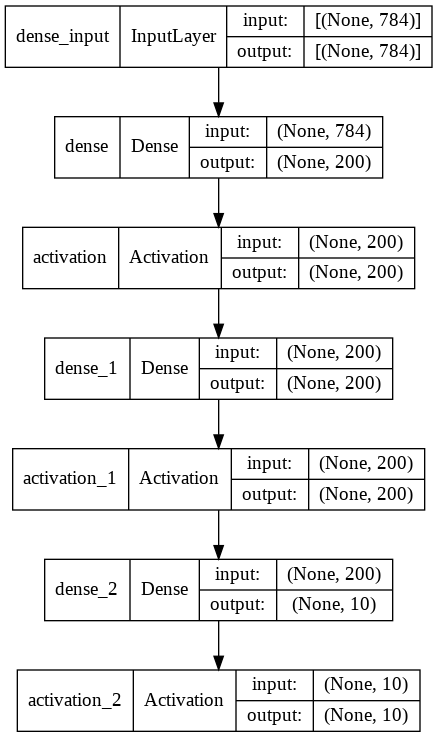

In [ ]:
# model = SimpleMLP()
tf.keras.utils.plot_model(global_model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
#declare path to your mnist data folder
img_path = 'trainingSet/trainingSet'

#get the path list using the path object
image_paths = list(paths.list_images(img_path))

#apply our function
image_list, label_list = load(image_paths, verbose=10000)

#binarize the labels
lb = LabelBinarizer()
label_list = lb.fit_transform(label_list)

[INFO] processed 10000/42000
[INFO] processed 20000/42000
[INFO] processed 30000/42000
[INFO] processed 40000/42000


In [ ]:
#split data into training and test set
X_train, X_test, y_train, y_test = train_test_split(image_list, 
                                                    label_list, 
                                                    test_size=0.1, 
                                                    random_state=42)

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(37800, 4200, 37800, 4200)

In [ ]:
#create clients
clients = create_clients(X_train, y_train, num_clients=10, initial='client')

In [ ]:
#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)
    
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

In [ ]:
lr = 0.01
comms_round = 20
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer = SGD(lr=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               )          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
#initialize global model

build_shape = 784 #(28, 28, 3)  # 1024 <- CIFAR-10    # 784 # for MNIST

smlp_global = SimpleMLP()
global_model = smlp_global.build(build_shape, 10) 
global_acc_list = []
global_loss_list = []

In [ ]:
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    all_client_names = list(clients_batched.keys())
           
    client_names = random.sample(all_client_names, k=10)
    # print(client_names, len(client_names))
    random.shuffle(client_names)
    
#     if debug: 
#         # print('all_client_names', all_client_names)
#         print('client_names', client_names, len(client_names))
                
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(build_shape, 10)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=1, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = 0.1 # weight_scalling_factor(clients_batched, client)
        # print('scaling_factor', scaling_factor)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        global_acc_list.append(global_acc)
        global_loss_list.append(global_loss)

comm_round: 0 | global_acc: 41.071% | global_loss: 2.2585582733154297
comm_round: 1 | global_acc: 50.262% | global_loss: 2.2031443119049072
comm_round: 2 | global_acc: 57.143% | global_loss: 2.142970085144043
comm_round: 3 | global_acc: 61.976% | global_loss: 2.089998245239258
comm_round: 4 | global_acc: 65.167% | global_loss: 2.0482840538024902
comm_round: 5 | global_acc: 66.452% | global_loss: 2.012636184692383
comm_round: 6 | global_acc: 68.119% | global_loss: 1.984912633895874
comm_round: 7 | global_acc: 69.524% | global_loss: 1.962205410003662
comm_round: 8 | global_acc: 71.095% | global_loss: 1.942123532295227
comm_round: 9 | global_acc: 72.571% | global_loss: 1.9244935512542725
comm_round: 10 | global_acc: 73.524% | global_loss: 1.908677101135254
comm_round: 11 | global_acc: 74.500% | global_loss: 1.8962006568908691
comm_round: 12 | global_acc: 75.167% | global_loss: 1.8842144012451172
comm_round: 13 | global_acc: 76.500% | global_loss: 1.8738600015640259
comm_round: 14 | global

IID | total comm rounds 20


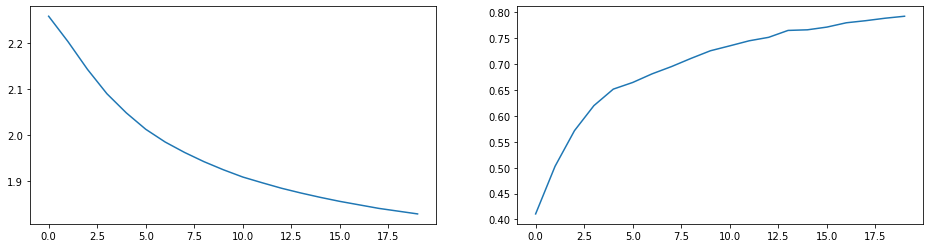

In [ ]:
# IID 
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(list(range(0,len(global_loss_list))), global_loss_list)
plt.subplot(122)
plt.plot(list(range(0,len(global_acc_list))), global_acc_list)
print('IID | total comm rounds', len(global_acc_list))

In [ ]:
iid_df = pd.DataFrame(list(zip(global_acc_list, global_loss_list)), columns =['global_acc_list', 'global_loss_list'])
iid_df.to_csv('MNIST_IID.csv',index=False)

### Non - IID

In [ ]:
def create_clients(image_list, label_list, num_clients=100, initial='clients'):
    ''' return: a dictionary with keys clients' names and value as 
                data shards - tuple of images and label lists.
        args: 
            image_list: a list of numpy arrays of training images
            label_list:a list of binarized labels for each image
            num_client: number of fedrated members (clients)
            initials: the clients'name prefix, e.g, clients_1 
            
    '''

    #create a list of client names
    client_names = ['{}_{}'.format(initial, i+1) for i in range(num_clients)]

    #randomize the data
    # data = list(zip(image_list, label_list))
    # random.shuffle(data)  # <- IID
    
    # sort data for non-iid
    max_y = np.argmax(label_list, axis=-1)
    sorted_zip = sorted(zip(max_y, label_list, image_list), key=lambda x: x[0])
    data = [(x,y) for _,y,x in sorted_zip]

    #shard data and place at each client
    size = len(data)//num_clients
    shards = [data[i:i + size] for i in range(0, size*num_clients, size)]

    #number of clients must equal number of shards
    assert(len(shards) == len(client_names))

    return {client_names[i] : shards[i] for i in range(len(client_names))} 

In [ ]:
len(X_train), len(X_test), len(y_train), len(y_test)

(37800, 4200, 37800, 4200)

In [ ]:
#create clients
clients = create_clients(X_train, y_train, num_clients=100, initial='client')

In [ ]:
#process and batch the training data for each client
clients_batched = dict()
for (client_name, data) in clients.items():
    clients_batched[client_name] = batch_data(data)
    
#process and batch the test set  
test_batched = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(len(y_test))

In [ ]:
lr = 0.01 
comms_round = 20
loss='categorical_crossentropy'
metrics = ['accuracy']
optimizer = SGD(lr=lr, 
                decay=lr / comms_round, 
                momentum=0.9
               )          

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
#initialize global model

build_shape = 784 #(32, 32, 3)  # 1024 <- CIFAR-10    # 784 # for MNIST

smlp_global = SimpleMLP()
global_model = smlp_global.build(build_shape, 10) 
global_acc_list = []
global_loss_list = []

In [ ]:
#commence global training loop
for comm_round in range(comms_round):
            
    # get the global model's weights - will serve as the initial weights for all local models
    global_weights = global_model.get_weights()
    
    #initial list to collect local model weights after scalling
    scaled_local_weight_list = list()

    #randomize client data - using keys
    all_client_names = list(clients_batched.keys())
           
    client_names = random.sample(all_client_names, k=10)
    random.shuffle(client_names)
    if debug: 
        # print('all_client_names', all_client_names)
        print('client_names', client_names)
    
    #loop through each client and create new local model
    for client in client_names:
        smlp_local = SimpleMLP()
        local_model = smlp_local.build(build_shape, 10)
        local_model.compile(loss=loss, 
                      optimizer=optimizer, 
                      metrics=metrics)
        
        #set local model weight to the weight of the global model
        local_model.set_weights(global_weights)
        
        #fit local model with client's data
        local_model.fit(clients_batched[client], epochs=1, verbose=0)
        
        #scale the model weights and add to list
        scaling_factor = 0.1 # weight_scalling_factor(clients_batched, client)
        scaled_weights = scale_model_weights(local_model.get_weights(), scaling_factor)
        scaled_local_weight_list.append(scaled_weights)
        
        #clear session to free memory after each communication round
        K.clear_session()
        
    #to get the average over all the local model, we simply take the sum of the scaled weights
    average_weights = sum_scaled_weights(scaled_local_weight_list)
    
    #update global model 
    global_model.set_weights(average_weights)

    #test global model and print out metrics after each communications round
    for(X_test, Y_test) in test_batched:
        global_acc, global_loss = test_model(X_test, Y_test, global_model, comm_round)
        global_acc_list.append(global_acc)
        global_loss_list.append(global_loss)

comm_round: 0 | global_acc: 11.810% | global_loss: 2.2920494079589844
comm_round: 1 | global_acc: 22.381% | global_loss: 2.255349636077881
comm_round: 2 | global_acc: 8.595% | global_loss: 2.297943115234375
comm_round: 3 | global_acc: 22.167% | global_loss: 2.2343640327453613
comm_round: 4 | global_acc: 21.690% | global_loss: 2.2224576473236084
comm_round: 5 | global_acc: 31.167% | global_loss: 2.206035614013672
comm_round: 6 | global_acc: 40.786% | global_loss: 2.171427011489868
comm_round: 7 | global_acc: 31.833% | global_loss: 2.174037456512451
comm_round: 8 | global_acc: 44.262% | global_loss: 2.1426572799682617
comm_round: 9 | global_acc: 36.762% | global_loss: 2.1348814964294434
comm_round: 10 | global_acc: 46.667% | global_loss: 2.105984926223755
comm_round: 11 | global_acc: 53.429% | global_loss: 2.057070732116699
comm_round: 12 | global_acc: 51.262% | global_loss: 2.0491318702697754
comm_round: 13 | global_acc: 58.095% | global_loss: 2.0158350467681885
comm_round: 14 | global_

Non-IID | total comm rounds 20


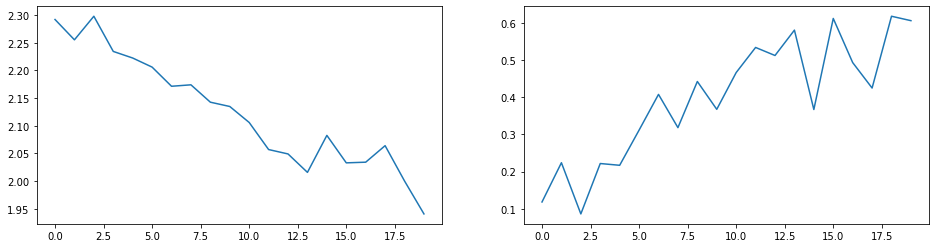

In [ ]:
# Non-IID 
import matplotlib.pyplot as plt
plt.figure(figsize=(16,4))
plt.subplot(121)
plt.plot(list(range(0,len(global_loss_list))), global_loss_list)
plt.subplot(122)
plt.plot(list(range(0,len(global_acc_list))), global_acc_list)
print('Non-IID | total comm rounds', len(global_acc_list))           

In [ ]:
noniid_df = pd.DataFrame(list(zip(global_acc_list, global_loss_list)), columns =['global_acc_list', 'global_loss_list'])
noniid_df.to_csv('MNIST_Non-IID.csv',index=False)